##Customer Segmentation using RFM & Clustering

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load customer data
customer_df = pd.read_csv('/content/drive/MyDrive/GlobalSuperstore_Project/data/processed/customer_segmentation.csv')
print(f"Customers: {len(customer_df)}")

Customers: 1590


In [ ]:
# Prepare RFM data
rfm_df = customer_df[['Customer_Recency', 'Customer_Frequency', 'Customer_Monetary']].copy()
rfm_df.columns = ['Recency', 'Frequency', 'Monetary']

In [ ]:
# Handle infinite values
rfm_df = rfm_df.replace([np.inf, -np.inf], np.nan).dropna()

In [ ]:
# Log transform for Monetary (right-skewed)
rfm_df['Monetary_log'] = np.log1p(rfm_df['Monetary'])

In [ ]:
# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary_log']])

In [ ]:
# Determine optimal clusters
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

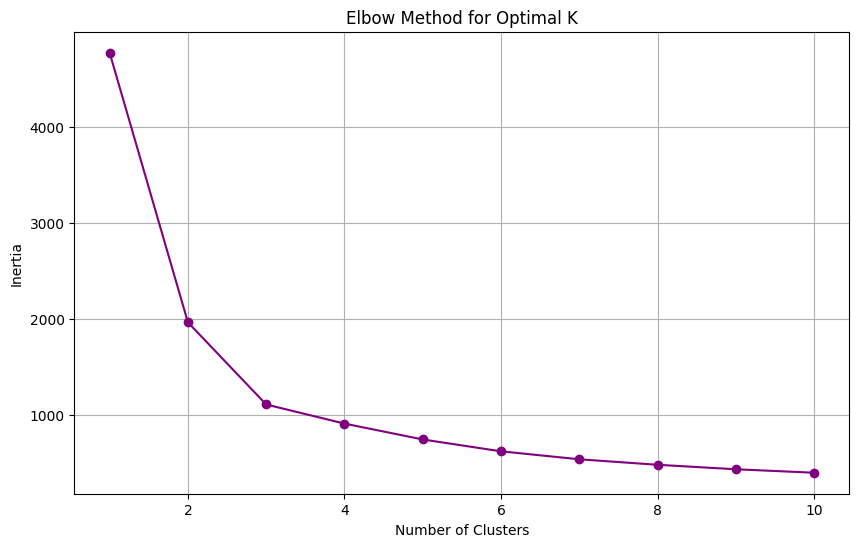

In [ ]:

# Plot elbow curve
plt.figure(figsize=(10,6))
plt.plot(k_range, inertia, color='purple', marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.savefig('/content/drive/MyDrive/GlobalSuperstore_Project/data/model_outputs/elbow_curve.png', dpi=300)
plt.show()

In [ ]:
# based on elbow
optimal_k = 4

In [16]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [17]:
# Analyze clusters
cluster_summary = customer_df.groupby('Cluster').agg({
    'Customer_Recency': ['mean', 'std'],
    'Customer_Frequency': ['mean', 'std'],
    'Customer_Monetary': ['mean', 'std', 'count']
}).round(2)

print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
        Customer_Recency         Customer_Frequency       Customer_Monetary  \
                    mean     std               mean   std              mean   
Cluster                                                                       
0                 207.89   69.65               5.48  2.24           1656.09   
1                  28.72   26.96              26.15  4.88          13887.20   
2                  49.81   39.46               7.21  2.48           2433.83   
3                 513.46  162.23               4.01  1.93           1344.59   

                        
             std count  
Cluster                 
0        1429.07   226  
1        4925.11   789  
2        1679.13   494  
3        1421.71    81  


In [18]:
# Name the clusters based on characteristics
cluster_names = {
    0: 'Loyal Customers',
    1: 'At-Risk Customers',
    2: 'New Customers',
    3: 'VIP Customers'
}

customer_df['Segment_Name'] = customer_df['Cluster'].map(cluster_names)

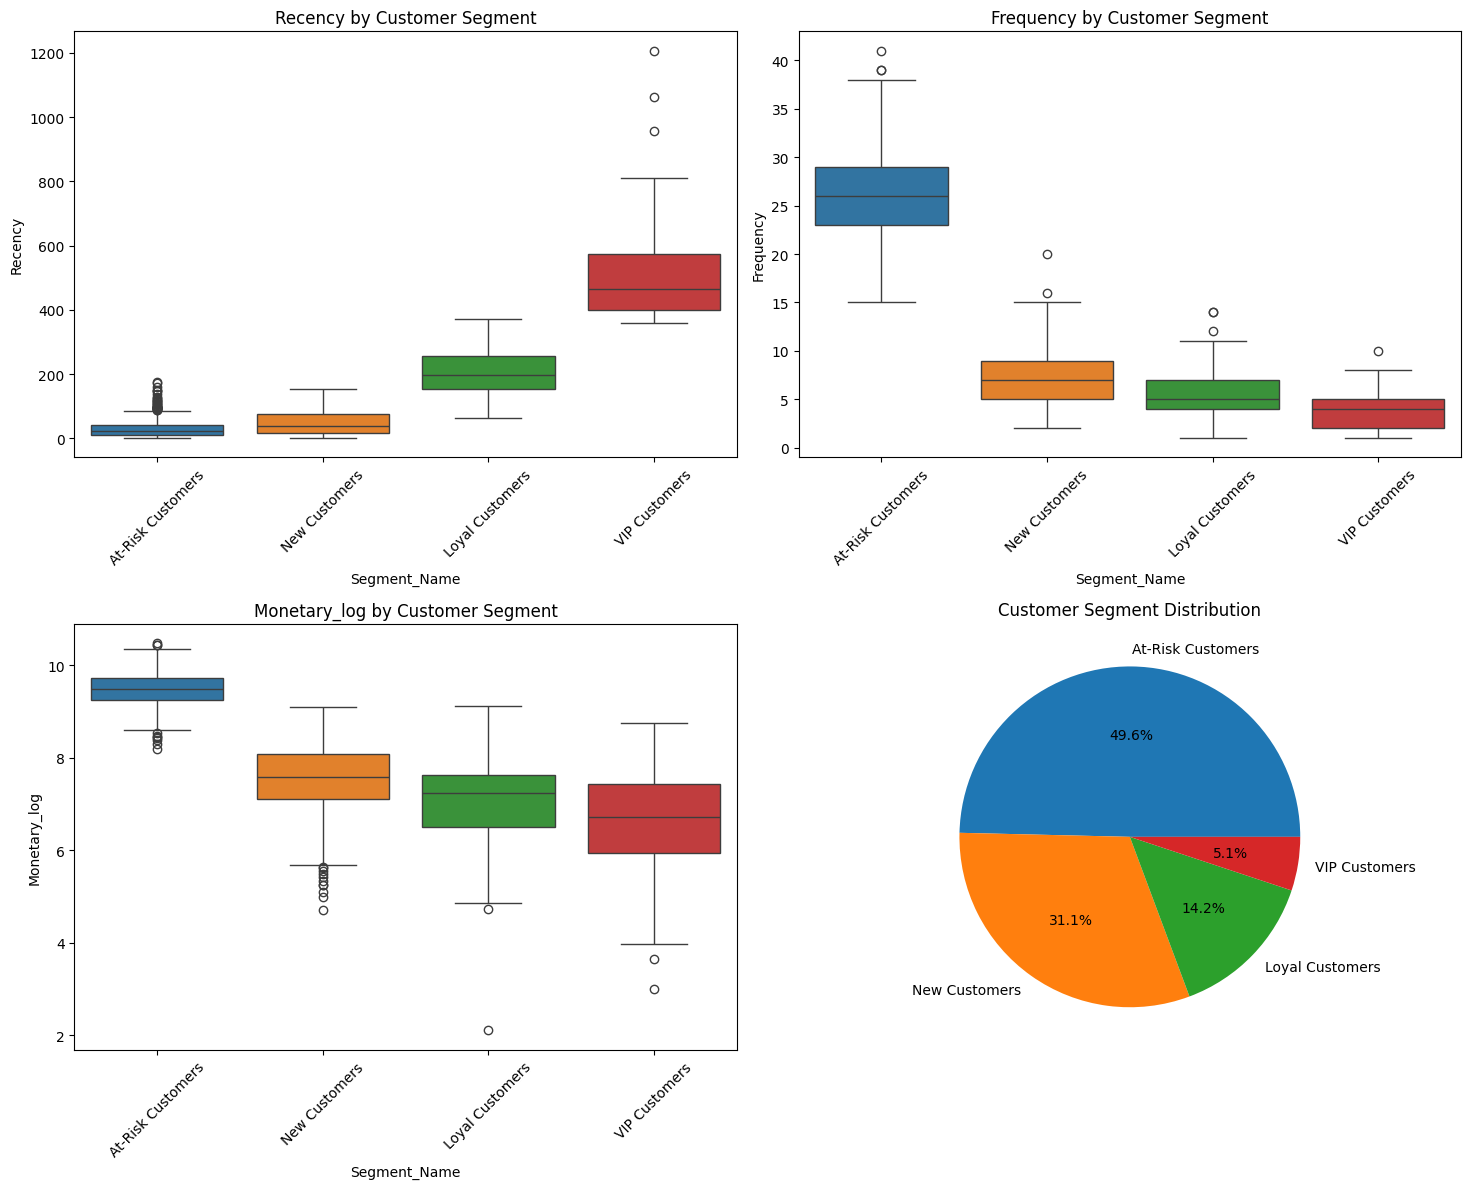

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize clusters
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# RFM Distribution by Cluster
for idx, (rfm_col, ax) in enumerate(zip(['Recency', 'Frequency', 'Monetary_log', 'Segment_Name'], axes.flatten())):
    if rfm_col != 'Segment_Name':
        sns.boxplot(x='Segment_Name', y=rfm_col, data=pd.concat([rfm_df, customer_df['Segment_Name']], axis=1), ax=ax, hue='Segment_Name', legend=False) # Added hue and removed legend as x and hue are same
        ax.set_title(f'{rfm_col} by Customer Segment')
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    else:
        segment_counts = customer_df['Segment_Name'].value_counts()
        ax.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%')
        ax.set_title('Customer Segment Distribution')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/GlobalSuperstore_Project/data/model_outputs/customer_segments.png', dpi=300)
plt.show()

In [23]:
# Save segmented customers
customer_df.to_csv('/content/drive/MyDrive/GlobalSuperstore_Project/data/model_outputs/customers_segmented.csv', index=False)

# Create segment insights
segment_insights = []
for segment in customer_df['Segment_Name'].unique():
    segment_data = customer_df[customer_df['Segment_Name'] == segment]
    insights = {
        'Segment': segment,
        'Count': len(segment_data),
        'Percentage': (len(segment_data) / len(customer_df)) * 100,
        'Avg_Recency': segment_data['Customer_Recency'].mean(),
        'Avg_Frequency': segment_data['Customer_Frequency'].mean(),
        'Avg_Monetary': segment_data['Customer_Monetary'].mean(),
        'Total_Value': segment_data['Customer_Monetary'].sum(),
        'Recommendation': ''
    }

    # Add business recommendations
    if segment == 'VIP Customers':
        insights['Recommendation'] = 'Offer exclusive benefits, early access to new products'
    elif segment == 'Loyal Customers':
        insights['Recommendation'] = 'Loyalty program rewards, referral bonuses'
    elif segment == 'New Customers':
        insights['Recommendation'] = 'Welcome series, first purchase discount'
    elif segment == 'At-Risk Customers':
        insights['Recommendation'] = 'Re-engagement campaigns, special offers'

    segment_insights.append(insights)

segment_df = pd.DataFrame(segment_insights)
segment_df.to_csv('/content/drive/MyDrive/GlobalSuperstore_Project/data/model_outputs/segment_insights.csv', index=False)

print("Customer segmentation completed!")
print(f"\nSegments created: {customer_df['Segment_Name'].unique().tolist()}")

Customer segmentation completed!

Segments created: ['At-Risk Customers', 'New Customers', 'Loyal Customers', 'VIP Customers']
